### This (auxiliary) notebook shows CelebA/LSUN classifier training and evaluation according to conventional performance metrics

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from datasets import *
from ml_util import *
from cnn import *
from adversarial_generation import *
from evaluation_util import EvaluationUtil

### Load dataset

* Comment/uncomment to switch between CelebA and LSUN

In [2]:
dataset_info = DatasetInfo.CelebA128Gender
#dataset_info = DatasetInfo.LSUN128

if dataset_info == DatasetInfo.CelebA128Gender:
    trainer_name = "celeba-128"
    ds = CelebAData(20)
elif dataset_info == DatasetInfo.LSUN128:
    trainer_name = "lsun-128"
    ds = LSUNData()
else:
    raise RuntimeError()
class_weights = [0.5] * 2

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


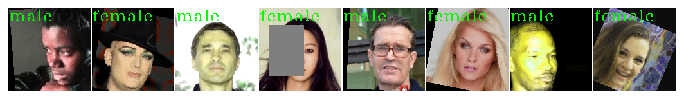

In [3]:
# get some random training images (with conventional data augmentation)
images, labels = next(iter(ds.get_train_loader(batch_size=8)))
Util.imshow_tensors(images, captions=ds.prediction_indices_to_printed_classes(labels), nrow=8)

### Load classifiers

In [4]:
filenames = "oneepoch plain conventional robust both".split(" ")
def load_classifier(weights_filename: str):
    c = Trainer(trainer_name, ds.get_train_loader, ds.get_test_loader)
    c.restore_params_from_disk(weights_filename)
    return c
classifiers = [load_classifier(f"new_classifiers/{filename}_{dataset_info.name}.bin") for filename in filenames]

celeba-128 classifier: 300138 trainable parameters
celeba-128 classifier: 300138 trainable parameters
celeba-128 classifier: 300138 trainable parameters
celeba-128 classifier: 300138 trainable parameters
celeba-128 classifier: 300138 trainable parameters


### A few predictions

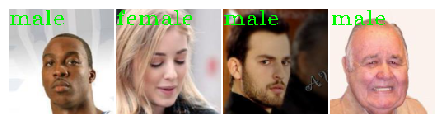

Predicted 0: ['male', 'female', 'male', 'male']
Predicted 1: ['male', 'female', 'male', 'male']
Predicted 2: ['male', 'female', 'male', 'male']
Predicted 3: ['male', 'female', 'male', 'male']
Predicted 4: ['male', 'female', 'male', 'male']


In [5]:
EvaluationUtil.show_some_predictions(classifiers, ds)

### Classifier evaluation: clean accuracy and noise corruption accuracy (on the validation set)

In [6]:
EvaluationUtil.evaluate_accuracy(classifiers, ds, 100)

Accuracy of classifier 0 on 100 validation images (noise 0.0):  94.00%
Accuracy of classifier 0 on 100 validation images (noise 0.8):  87.00%
Accuracy of classifier 1 on 100 validation images (noise 0.0):  99.00%
Accuracy of classifier 1 on 100 validation images (noise 0.8):  74.00%
Accuracy of classifier 2 on 100 validation images (noise 0.0):  95.00%
Accuracy of classifier 2 on 100 validation images (noise 0.8):  45.00%
Accuracy of classifier 3 on 100 validation images (noise 0.0): 100.00%
Accuracy of classifier 3 on 100 validation images (noise 0.8):  94.00%
Accuracy of classifier 4 on 100 validation images (noise 0.0):  95.00%
Accuracy of classifier 4 on 100 validation images (noise 0.8):  92.00%


### Evaluation: adversarial frequency and severity in the original space (on the validation set)

* Adversarial frequency = accuracy on worst-case perturbed images within allowed bounds
* Adversarial severity = expected size of a minimum adversarial perturbation

In [7]:
EvaluationUtil.evaluate_conventional_robustness(classifiers, ds, 4, l_2_bounds=[0.0025, 0.005], l_inf_bounds=[0.005, 0.01])

For classifier 0, (scaled_l_2) ║Δx║ ≤ 0.002500, accuracy on 4 images =  50.00%
For classifier 1, (scaled_l_2) ║Δx║ ≤ 0.002500, accuracy on 4 images =  25.00%
For classifier 2, (scaled_l_2) ║Δx║ ≤ 0.002500, accuracy on 4 images =  25.00%
For classifier 3, (scaled_l_2) ║Δx║ ≤ 0.002500, accuracy on 4 images = 100.00%
For classifier 4, (scaled_l_2) ║Δx║ ≤ 0.002500, accuracy on 4 images = 100.00%
For classifier 0, (scaled_l_2) ║Δx║ ≤ 0.005000, accuracy on 4 images =  50.00%
For classifier 1, (scaled_l_2) ║Δx║ ≤ 0.005000, accuracy on 4 images =  50.00%
For classifier 2, (scaled_l_2) ║Δx║ ≤ 0.005000, accuracy on 4 images =  25.00%
For classifier 3, (scaled_l_2) ║Δx║ ≤ 0.005000, accuracy on 4 images = 100.00%
For classifier 4, (scaled_l_2) ║Δx║ ≤ 0.005000, accuracy on 4 images =  75.00%
For classifier 0, (     l_inf) ║Δx║ ≤ 0.005000, accuracy on 4 images = 100.00%
For classifier 1, (     l_inf) ║Δx║ ≤ 0.005000, accuracy on 4 images = 100.00%
For classifier 2, (     l_inf) ║Δx║ ≤ 0.005000, accu

In [8]:
EvaluationUtil.evaluate_conventional_adversarial_severity(classifiers, ds, 4, OTHER_L2_UPPER_BOUND, OTHER_LINF_UPPER_BOUND)

Adversarial severity of classifier 0 with scaled_l_2 norm = 0.00415457 (std = 0.00393316, #images = 4)
Adversarial severity of classifier 1 with scaled_l_2 norm = 0.00515843 (std = 0.00065383, #images = 4)
Adversarial severity of classifier 2 with scaled_l_2 norm = 0.00347468 (std = 0.00193156, #images = 4)
Adversarial severity of classifier 3 with scaled_l_2 norm = 0.01401526 (std = 0.00684471, #images = 4)
Adversarial severity of classifier 4 with scaled_l_2 norm = 0.00712712 (std = 0.00454690, #images = 4)
Adversarial severity of classifier 0 with      l_inf norm = 0.01015950 (std = 0.01148564, #images = 4)
Adversarial severity of classifier 1 with      l_inf norm = 0.01286419 (std = 0.00757122, #images = 4)
Adversarial severity of classifier 2 with      l_inf norm = 0.01305442 (std = 0.00948119, #images = 4)
Adversarial severity of classifier 3 with      l_inf norm = 0.03299014 (std = 0.02027731, #images = 4)
Adversarial severity of classifier 4 with      l_inf norm = 0.04110306 (s

### Evaluation: optimize class activations

* Robust classifiers should be capable of limited image generation by maximizing their class activations
* Here, this is visible only on CelebA

classifier 0:


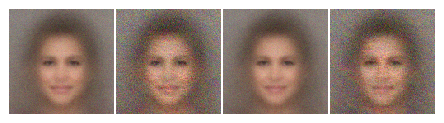

classifier 1:


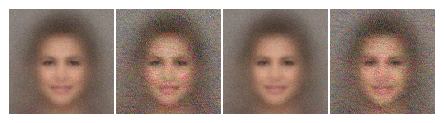

classifier 2:


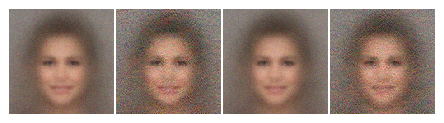

classifier 3:


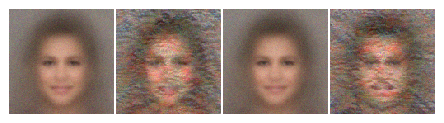

classifier 4:


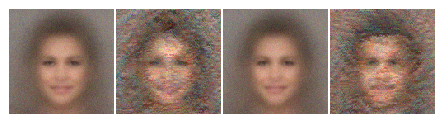

In [9]:
if dataset_info == DatasetInfo.CelebA128Gender:
    EvaluationUtil.generate_images_with_classifier(classifiers, ds, 2, 0.05, "l_inf", 0.3)
elif dataset_info == DatasetInfo.LSUN128:
    EvaluationUtil.generate_images_with_classifier(classifiers, ds, 2, 0.1, "scaled_l_2", 0.6)